In [1]:
# Built-in
import os
import json
import random
from copy import deepcopy

# Numerical & Data Handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn Metrics & Preprocessing
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    average_precision_score,
    precision_recall_fscore_support
)
from sklearn.preprocessing import label_binarize

# SHAP (Model Explainability)
import shap

2025-07-21 16:36:48.427685: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 16:36:48.435950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753083408.446224  756532 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753083408.449105  756532 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-21 16:36:48.459585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
##########################################
# 1. 랜덤 시드 설정
##########################################

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

    g = torch.Generator()
    g.manual_seed(seed)
    return g
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(42)
torch.manual_seed(42)
np.random.seed(42)
# torch.use_deterministic_algorithms(True)

os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

g = set_seed(42)

In [3]:
##########################################
# 2. 멀티모달 Dataset 클래스
##########################################
class MultiModalDataset(Dataset):
    """
    각 샘플이 (2D STFT, 1D Raw Signal, Label) 형태로 구성된 Dataset.
    2D STFT 데이터: (3, Freq_bins, Time_bins)
    1D Raw Signal 데이터: (1, L) – 원신호의 길이 L (윈도우 개수는 두 모달 모두 동일)
    """
    def __init__(self, stft_data, raw_data, labels):
        assert len(stft_data) == len(raw_data) == len(labels), "모달리티 간 샘플 수가 다릅니다."
        self.stft_data = torch.tensor(stft_data, dtype=torch.float32)
        self.raw_data = torch.tensor(raw_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.stft_data[idx], self.raw_data[idx], self.labels[idx]

##########################################
# 3. npy 파일 로드 함수 (멀티모달)
##########################################
def load_data_from_dir(data_dir, file_map, split_name):
    """
    STFT 데이터 (2D)를 로드하는 함수.
    data_dir: 예를 들어 "processed_data_0208_npy/train"
    file_map: 클래스별 npy 파일 이름 매핑 (확장자 제외)
    """
    data = []
    labels = []
    class_labels = {"normal": 0, "abnormal_1": 1, "abnormal_2": 2, "abnormal_3": 3, "abnormal_4": 4}
    for class_name, files in file_map.items():
        for file_name in files:
            file_path = os.path.join(data_dir, f"{file_name}.npy")
            if os.path.exists(file_path):
                tensor_data = np.load(file_path)
                data.append(tensor_data)
                labels.extend([class_labels[class_name]] * tensor_data.shape[0])
                print(f"Loaded {file_name} with shape {tensor_data.shape} for class '{class_name}' ({split_name})")
            else:
                print(f"File not found: {file_path}")
    if data:
        return np.concatenate(data, axis=0), np.array(labels)
    else:
        return np.array([]), np.array([])

def load_raw_data_from_dir(data_dir, file_map, split_name):
    """
    1D raw signal 데이터를 로드하는 함수.
    data_dir: 예를 들어 "processed_data_1D_npy_temp/train"
    file_map: 클래스별 npy 파일 이름 매핑 (확장자 제외)
    """
    data = []
    labels = []
    class_labels = {"normal": 0, "abnormal_1": 1, "abnormal_2": 2, "abnormal_3": 3, "abnormal_4": 4}
    for class_name, files in file_map.items():
        for file_name in files:
            file_path = os.path.join(data_dir, f"{file_name}.npy")
            if os.path.exists(file_path):
                tensor_data = np.load(file_path)
                data.append(tensor_data)
                labels.extend([class_labels[class_name]] * tensor_data.shape[0])
                print(f"Loaded {file_name} with shape {tensor_data.shape} for class '{class_name}' ({split_name})")
            else:
                print(f"File not found: {file_path}")
    if data:
        return np.concatenate(data, axis=0), np.array(labels)
    else:
        return np.array([]), np.array([])

def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)

##########################################
# 4. 파일 매핑
##########################################
stft_file_maps = {
    "train": {
        "normal"     : ["normal_stft_tensors"],
        "abnormal_1" : ["abnormal_1_stft_tensors"],
        "abnormal_2" : ["abnormal_2_stft_tensors"],
        "abnormal_3" : ["abnormal_3_stft_tensors"],
        "abnormal_4" : ["abnormal_4_stft_tensors"],
    },
    "val": {
        "normal"     : ["normal_stft_tensors"],
        "abnormal_1" : ["abnormal_1_stft_tensors"],
        "abnormal_2" : ["abnormal_2_stft_tensors"],
        "abnormal_3" : ["abnormal_3_stft_tensors"],
        "abnormal_4" : ["abnormal_4_stft_tensors"],
    },
    "test": {
        "normal"     : ["normal_stft_tensors"],
        "abnormal_1" : ["abnormal_1_stft_tensors"],
        "abnormal_2" : ["abnormal_2_stft_tensors"],
        "abnormal_3" : ["abnormal_3_stft_tensors"],
        "abnormal_4" : ["abnormal_4_stft_tensors"],
    }
}

raw_file_maps = {
    "train": {
        "normal"     : ["normal_raw_tensors"],
        "abnormal_1" : ["abnormal_1_raw_tensors"],
        "abnormal_2" : ["abnormal_2_raw_tensors"],
        "abnormal_3" : ["abnormal_3_raw_tensors"],
        "abnormal_4" : ["abnormal_4_raw_tensors"],
    },
    "val": {
        "normal"     : ["normal_raw_tensors"],
        "abnormal_1" : ["abnormal_1_raw_tensors"],
        "abnormal_2" : ["abnormal_2_raw_tensors"],
        "abnormal_3" : ["abnormal_3_raw_tensors"],
        "abnormal_4" : ["abnormal_4_raw_tensors"],
    },
    "test": {
        "normal"     : ["normal_raw_tensors"],
        "abnormal_1" : ["abnormal_1_raw_tensors"],
        "abnormal_2" : ["abnormal_2_raw_tensors"],
        "abnormal_3" : ["abnormal_3_raw_tensors"],
        "abnormal_4" : ["abnormal_4_raw_tensors"],
    }
}

def get_dataloader_set(
    stft_base_dir, raw_base_dir,
    val_aug=False, test_aug=False,
    batch_size=16, shuffle_train=True
):
    """
    증강 여부에 따라 val/test 데이터를 선택적으로 불러와 DataLoader 생성
    """
    # 경로 세팅
    train_stft_dir = os.path.join(stft_base_dir, "train")
    val_stft_dir   = os.path.join(stft_base_dir, "val_aug" if val_aug else "val")
    test_stft_dir  = os.path.join(stft_base_dir, "test_aug" if test_aug else "test")

    train_raw_dir = os.path.join(raw_base_dir, "train")
    val_raw_dir   = os.path.join(raw_base_dir, "val_aug" if val_aug else "val")
    test_raw_dir  = os.path.join(raw_base_dir, "test_aug" if test_aug else "test")

    # 데이터 로딩
    train_stft, train_labels_stft = load_data_from_dir(train_stft_dir, stft_file_maps["train"], "train")
    val_stft, val_labels_stft     = load_data_from_dir(val_stft_dir, stft_file_maps["val"], "val")
    test_stft, test_labels_stft   = load_data_from_dir(test_stft_dir, stft_file_maps["test"], "test")

    train_raw, train_labels_raw = load_raw_data_from_dir(train_raw_dir, raw_file_maps["train"], "train")
    val_raw, val_labels_raw     = load_raw_data_from_dir(val_raw_dir, raw_file_maps["val"], "val")
    test_raw, test_labels_raw   = load_raw_data_from_dir(test_raw_dir, raw_file_maps["test"], "test")

    # 라벨 검증
    assert np.array_equal(train_labels_stft, train_labels_raw), "Train 라벨 불일치"
    assert np.array_equal(val_labels_stft, val_labels_raw),     "Val 라벨 불일치"
    assert np.array_equal(test_labels_stft, test_labels_raw),   "Test 라벨 불일치"

    # Dataset 생성
    train_dataset = MultiModalDataset(train_stft, train_raw, train_labels_stft)
    val_dataset   = MultiModalDataset(val_stft, val_raw, val_labels_stft)
    test_dataset  = MultiModalDataset(test_stft, test_raw, test_labels_stft)

    # DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )   

    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, worker_init_fn=seed_worker)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, worker_init_fn=seed_worker)

    return train_loader, val_loader, test_loader


# 기본 데이터 경로
stft_data_dir = "processed_data_stft"
raw_data_dir  = "processed_data_raw"
batch_size = 16

# DataLoader 생성

train_loader, val_loader, test_loader = get_dataloader_set(
    stft_data_dir, raw_data_dir, val_aug=False, test_aug=False, batch_size=batch_size
)


Loaded normal_stft_tensors with shape (1904, 3, 13, 16) for class 'normal' (train)
Loaded abnormal_1_stft_tensors with shape (1584, 3, 13, 16) for class 'abnormal_1' (train)
Loaded abnormal_2_stft_tensors with shape (2832, 3, 13, 16) for class 'abnormal_2' (train)
Loaded abnormal_3_stft_tensors with shape (1955, 3, 13, 16) for class 'abnormal_3' (train)
Loaded abnormal_4_stft_tensors with shape (2249, 3, 13, 16) for class 'abnormal_4' (train)
Loaded normal_stft_tensors with shape (156, 3, 13, 16) for class 'normal' (val)
Loaded abnormal_1_stft_tensors with shape (8, 3, 13, 16) for class 'abnormal_1' (val)
Loaded abnormal_2_stft_tensors with shape (14, 3, 13, 16) for class 'abnormal_2' (val)
Loaded abnormal_3_stft_tensors with shape (165, 3, 13, 16) for class 'abnormal_3' (val)
Loaded abnormal_4_stft_tensors with shape (190, 3, 13, 16) for class 'abnormal_4' (val)
Loaded normal_stft_tensors with shape (156, 3, 13, 16) for class 'normal' (test)
Loaded abnormal_1_stft_tensors with shape (

In [4]:
# (STFT, Raw, Label) → (STFT, Label) 만 가져오는 Dataset
class STFTDatasetOnly(torch.utils.data.Dataset):
    def __init__(self, multimodal_dataset):
        self.dataset = multimodal_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        stft, raw, label = self.dataset[idx]
        return stft, label

# (STFT, Raw, Label) → (Raw, Label) 만 가져오는 Dataset
class RawDatasetOnly(torch.utils.data.Dataset):
    def __init__(self, multimodal_dataset):
        self.dataset = multimodal_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        stft, raw, label = self.dataset[idx]
        return raw, label

# train_loader, val_loader, test_loader 가 이미 MultiModalDataset으로 되어 있으니까
# 여기서 새로 생성
train_dataset_stft = STFTDatasetOnly(train_loader.dataset)
val_dataset_stft   = STFTDatasetOnly(val_loader.dataset)
test_dataset_stft  = STFTDatasetOnly(test_loader.dataset)

train_dataset_raw  = RawDatasetOnly(train_loader.dataset)
val_dataset_raw    = RawDatasetOnly(val_loader.dataset)
test_dataset_raw   = RawDatasetOnly(test_loader.dataset)

# Loader 생성
train_loader_stft = DataLoader(train_dataset_stft, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader_stft   = DataLoader(val_dataset_stft, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader_stft  = DataLoader(test_dataset_stft, batch_size=batch_size, shuffle=False, num_workers=4)

train_loader_raw = DataLoader(train_dataset_raw, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader_raw   = DataLoader(val_dataset_raw, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader_raw  = DataLoader(test_dataset_raw, batch_size=batch_size, shuffle=False, num_workers=4)

In [5]:
# 학습 진행 함수
# Macro F1 Score를 기준으로 모델 학습 (멀티 모달)
def train_model_macro_f1_with_attn(model, train_loader, val_loader, criterion, optimizer,
                                   num_epochs, device, save_dir="saved_models", patience=5):
    os.makedirs(save_dir, exist_ok=True)

    best_val_f1 = 0.0
    best_model_path = os.path.join(save_dir, 'best_model.pth')
    val_macro_f1_list = []

    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for stft_batch, raw_batch, y_batch in train_loader:
            stft_batch, raw_batch, y_batch = stft_batch.to(device), raw_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs, _ = model(stft_batch, raw_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * stft_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_running_loss = 0.0
        y_true, y_pred = [], []

        with torch.no_grad():
            for stft_val, raw_val, y_val in val_loader:
                stft_val, raw_val, y_val = stft_val.to(device), raw_val.to(device), y_val.to(device)
                outputs, _ = model(stft_val, raw_val)
                loss = criterion(outputs, y_val)
                val_running_loss += loss.item() * stft_val.size(0)

                _, predicted = torch.max(outputs, 1)
                y_true.extend(y_val.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_f1 = f1_score(y_true, y_pred, average='macro')
        val_macro_f1_list.append(val_f1)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f} | Val Macro-F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), best_model_path)
            print(f"✅ Best model saved at epoch {epoch+1} (Macro-F1: {val_f1:.4f})")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"⛔ Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                break

    model.load_state_dict(torch.load(best_model_path))
    return model, val_macro_f1_list

# 모델 평가 함수
def evaluate_model(model, data_loader, device, label_names):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    with torch.no_grad():
        for stft_batch, raw_batch, y_batch in data_loader:
            stft_batch, raw_batch, y_batch = stft_batch.to(device), raw_batch.to(device), y_batch.to(device)
            outputs, _ = model(stft_batch, raw_batch)  # ⭐️ 여기 수정
            prob = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(prob.cpu().numpy())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - MultiModal CNN Model")
    plt.show()

    n_classes = len(label_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    pr_auc = average_precision_score(y_true_bin, y_prob, average='macro')
    print(f"Macro-average Precision-Recall AUC: {pr_auc:.4f}")


class FocalLoss(nn.Module):
    """
    Focal Loss 구현 (for multi-class classification)
    참고:
      - 'Focal Loss for Dense Object Detection' (Lin et al.)
      - https://arxiv.org/abs/1708.02002

    alpha: 클래스별 혹은 스칼라로 주어지는 균형 파라미터 (기본 1.0)
    gamma: 포컬 감마 (default=2.0)
    reduction: 'mean' or 'sum' or 'none'
    weight: 각 클래스별 가중치 (tensor), ex) class_weights
    """
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight  # e.g. tensor([w0, w1, w2, ...]) shape=(num_classes,)

    def forward(self, inputs, targets):
        """
        inputs: (N, C) shape 로 예측 logits
        targets: (N,) shape 로 정답 레이블 (0~C-1)
        """
        # ----- 1) Cross Entropy 계산 (reduction='none')
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        # shape: (N,)

        # ----- 2) pt = exp(-ce_loss) = 예측 확률(정답 클래스)
        pt = torch.exp(-ce_loss)

        # ----- 3) focal_loss = alpha * (1-pt)^gamma * ce_loss
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss
        # shape: (N,)

        # ----- 4) reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:  # 'none'
            return focal_loss
            

In [6]:
label_names = ["normal", "abnormal_1", "abnormal_2", "abnormal_3", "abnormal_4"]

class_labels = {"normal": 0, "abnormal_1": 1, "abnormal_2": 2, "abnormal_3": 3, "abnormal_4": 4}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Cross-Attention 모듈
# Query: STFT, Key/Value: Raw Signal
class CrossAttention(nn.Module):
    def __init__(self, query_dim, kv_dim, embed_dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.query_proj = nn.Linear(query_dim, embed_dim)
        self.key_proj = nn.Linear(kv_dim, embed_dim)
        self.value_proj = nn.Linear(kv_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, query_dim)

    def forward(self, query, key_value):
        B, T_q, D_q = query.size()
        T_kv, D_kv = key_value.size(1), key_value.size(2)

        Q = self.query_proj(query)
        K = self.key_proj(key_value)
        V = self.value_proj(key_value)

        head_dim = Q.size(-1) // self.num_heads
        Q = Q.view(B, T_q, self.num_heads, head_dim).transpose(1, 2)
        K = K.view(B, T_kv, self.num_heads, head_dim).transpose(1, 2)
        V = V.view(B, T_kv, self.num_heads, head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (head_dim ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T_q, -1)
        output = self.out_proj(attn_output)

        return output, attn_weights



# TCN 모듈
class TemporalConvNet(nn.Module):
    def __init__(self, in_channels, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_ch = in_channels if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            padding = (kernel_size - 1) * dilation // 2
            layers.append(nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding, dilation=dilation),
                nn.BatchNorm1d(out_ch),
                nn.ReLU(),
                nn.Dropout(dropout)
            ))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class MultiModal(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        # --- 2D CNN Branch ---
        self.conv2d_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn2d_1 = nn.BatchNorm2d(32)
        self.conv2d_2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2d_2 = nn.BatchNorm2d(64)

        # --- 1D CNN + TCN Branch ---
        self.conv1d_1 = nn.Conv1d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1d_1 = nn.BatchNorm1d(16)
        self.conv1d_2 = nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn1d_2 = nn.BatchNorm1d(32)

        self.tcn = TemporalConvNet(in_channels=32, num_channels=[32, 64], kernel_size=3, dropout=0.3)
        self.pool1d = nn.AdaptiveAvgPool1d(256)  # Output shape: (B, 64, 256)

        # --- Cross Attention ---
        self.cross_attn = CrossAttention(query_dim=64, kv_dim=64, embed_dim=64, num_heads=8)

        # --- Fully Connected ---
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x2d, x1d):
        B = x2d.size(0)

        # 2D CNN branch
        x2d = F.relu(self.bn2d_1(self.conv2d_1(x2d)))
        x2d = F.relu(self.bn2d_2(self.conv2d_2(x2d)))
        x2d_flat = x2d.permute(0, 2, 3, 1).reshape(B, -1, 64)  # (B, HW/4, 64)

        # 1D CNN + TCN branch
        x1d = F.relu(self.bn1d_1(self.conv1d_1(x1d)))
        x1d = F.relu(self.bn1d_2(self.conv1d_2(x1d)))
        x1d = self.tcn(x1d)  # (B, 64, L)
        x1d = self.pool1d(x1d).permute(0, 2, 1)  # (B, 256, 64)

        # Cross attention
        attended, _ = self.cross_attn(query=x1d, key_value=x2d_flat)
        x1d_attn = attended.mean(dim=1)  # (B, 64)

        # 2D feature summary
        x2d_feat = F.adaptive_avg_pool2d(x2d, (1, 1)).view(B, -1)  # (B, 64)

        # Fusion & Classification
        x = torch.cat([x1d_attn, x2d_feat], dim=1)  # (B, 128)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out, _
        
def build_model():
    return MultiModal()


# config 바탕으로 멀티 모달 모델 생성 함수
def build_model_from_config(config, num_classes=5):
    class MultiModal(nn.Module):
        def __init__(self):
            super().__init__()

            # --- 2D CNN Branch ---
            self.conv2d_1 = nn.Conv2d(
                3, 32, 
                kernel_size=config['conv2d1_kernel'], 
                padding=(config['conv2d1_kernel'] - 1) // 2
            )
            self.bn2d_1 = nn.BatchNorm2d(32)
            self.conv2d_2 = nn.Conv2d(
                32, 64, 
                kernel_size=config['conv2d2_kernel'], 
                stride=2,
                padding=(config['conv2d2_kernel'] - 1) // 2
            )
            self.bn2d_2 = nn.BatchNorm2d(64)

            # --- 1D TCN Branch (Only TCN) ---
            self.tcn = TemporalConvNet(
                in_channels=3,  # ✅ 바로 3채널
                num_channels=config['tcn_channels'],
                kernel_size=config['tcn_kernel_size'],
                dropout=config['dropout_rate']
            )
            self.pool1d_final = nn.AdaptiveAvgPool1d(128)

            # --- Cross Attention ---
            self.cross_attn = CrossAttention(
                query_dim=config['tcn_channels'][-1],
                kv_dim=64,
                embed_dim=config['embed_dim'],
                num_heads=config['num_heads']
            )

            # --- Fully Connected ---
            fc1_dim = config['fc1_dim']
            self.fc1 = nn.Linear(config['tcn_channels'][-1] + 64, fc1_dim)
            self.dropout = nn.Dropout(config['dropout_rate'])
            self.fc2 = nn.Linear(fc1_dim, num_classes)

        def forward(self, x2d, x1d):
            B = x2d.size(0)

            # 2D CNN Branch
            x2d = F.relu(self.bn2d_1(self.conv2d_1(x2d)))
            x2d = F.relu(self.bn2d_2(self.conv2d_2(x2d)))
            x2d_flat = x2d.permute(0, 2, 3, 1).reshape(B, -1, 64)

            # 1D TCN Branch
            x1d = self.tcn(x1d)  # (B, C, L)
            x1d = self.pool1d_final(x1d).permute(0, 2, 1)  # (B, 128, C)

            # Cross Attention
            attended, _ = self.cross_attn(query=x1d, key_value=x2d_flat)
            x1d_attn = attended.mean(dim=1)
    
            # Final FC
            x2d_feat = F.adaptive_avg_pool2d(x2d, (1, 1)).view(B, -1)
            x = torch.cat([x1d_attn, x2d_feat], dim=1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            out = self.fc2(x)
            return out, _

    return MultiModal()

In [8]:
# STFT + Raw 샘플 각각에 대한 SHAP 계산 함수
def compute_shap_for_selected_samples(model, background_stft, background_raw,
                                      selected_stft, selected_raw):
    """
    단일 샘플에 대한 STFT, Raw SHAP 계산

    Args:
        model: 학습된 모델 (CrossAttention 포함)
        background_stft: (N, 3, Freq, Time)
        background_raw:  (N, 3, L)
        selected_stft:   (B, 3, Freq, Time)
        selected_raw:    (B, 3, L)

    Returns:
        shap_values: List of [STFT_SHAP, Raw_SHAP] for each class index
    """
    # 1) Wrapper 정의
    class MultiModalWrapper(nn.Module):
        def __init__(self, multimodal_model):
            super().__init__()
            self.model = multimodal_model

        def forward(self, *inputs):
            stft_in, raw_in = inputs
            logits, _ = self.model(stft_in, raw_in)
            return logits

    model.eval()
    wrapper = MultiModalWrapper(model).to(device)

    # 2) SHAP Explainer
    explainer = shap.DeepExplainer(
        model=wrapper,
        data=[background_stft, background_raw]
    )

    # 3) SHAP 값 계산
    shap_values = explainer.shap_values([selected_stft, selected_raw])
    return shap_values

In [9]:
# 베스트 모델과 예측 인덱스를 가져오는 함수
def get_best_model_and_indices(model_dir):
    best_f1 = -1
    best_trial = None

    for trial_name in os.listdir(model_dir):
        trial_path = os.path.join(model_dir, trial_name)
        metrics_path = os.path.join(trial_path, "metrics.json")
        if os.path.exists(metrics_path):
            with open(metrics_path, "r") as f:
                metrics = json.load(f)
                macro_f1 = metrics.get("macro_f1", 0)
                if macro_f1 > best_f1:
                    best_f1 = macro_f1
                    best_trial = trial_name

    if best_trial is None:
        raise ValueError("No valid trials found.")

    best_trial_path = os.path.join(model_dir, best_trial)
    best_model_path = os.path.join(best_trial_path, "best_model.pth")
    predicted_indices_path = os.path.join(best_trial_path, "predicted_indices.json")

    print(f"✅ Best trial: {best_trial} (Macro-F1: {best_f1:.4f})")
    return best_model_path, predicted_indices_path

In [10]:
# 모델 디렉토리와 실행 횟수, 클래스 이름을 받아서 요약 저장
def save_summary(model_dir, n_runs, class_names):
    macro_f1s = []
    accuracies = []
    precision_by_class = {cls: [] for cls in class_names}
    recall_by_class = {cls: [] for cls in class_names}
    f1_by_class = {cls: [] for cls in class_names}

    for r in range(1, n_runs + 1):
        metrics_path = os.path.join(model_dir, f"trial_{r}", "metrics.json")
        with open(metrics_path, "r") as f:
            m = json.load(f)

        macro_f1s.append(m["macro_f1"])
        accuracies.append(m.get("accuracy", 0))  # accuracy 없으면 0 처리

        for cls in class_names:
            cls_scores = m["class_scores"].get(cls, {"precision": 0, "recall": 0, "f1": 0})
            precision_by_class[cls].append(cls_scores["precision"])
            recall_by_class[cls].append(cls_scores["recall"])
            f1_by_class[cls].append(cls_scores["f1"])

    summary = {
        "macro_f1": {"mean": float(np.mean(macro_f1s)), "std": float(np.std(macro_f1s))},
        "accuracy": {"mean": float(np.mean(accuracies)), "std": float(np.std(accuracies))},
        "class_scores": {
            cls: {
                "precision": {
                    "mean": float(np.mean(precision_by_class[cls])),
                    "std": float(np.std(precision_by_class[cls]))
                },
                "recall": {
                    "mean": float(np.mean(recall_by_class[cls])),
                    "std": float(np.std(recall_by_class[cls]))
                },
                "f1": {
                    "mean": float(np.mean(f1_by_class[cls])),
                    "std": float(np.std(f1_by_class[cls]))
                }
            }
            for cls in class_names
        }
    }

    # Save to JSON
    with open(os.path.join(model_dir, "summary.json"), "w") as f:
        json.dump(summary, f, indent=2)

    # Save to CSV
    rows = [
        {"metric": "macro_f1", "mean": summary["macro_f1"]["mean"], "std": summary["macro_f1"]["std"]},
        {"metric": "accuracy", "mean": summary["accuracy"]["mean"], "std": summary["accuracy"]["std"]}
    ]
    for cls in class_names:
        for metric in ["precision", "recall", "f1"]:
            rows.append({
                "metric": f"{cls}_{metric}",
                "mean": summary["class_scores"][cls][metric]["mean"],
                "std": summary["class_scores"][cls][metric]["std"]
            })

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(model_dir, "summary.csv"), index=False)

    print(f"✅ Saved extended summary in {model_dir}")

### 1. 멀티모달 모델


🔁 Run 1/5 -------------------
Epoch [1/50] | Train Loss: 0.1482 | Val Macro-F1: 0.8078
✅ Best model saved at epoch 1 (Macro-F1: 0.8078)
Epoch [2/50] | Train Loss: 0.0393 | Val Macro-F1: 0.7595
Epoch [3/50] | Train Loss: 0.0266 | Val Macro-F1: 0.8405
✅ Best model saved at epoch 3 (Macro-F1: 0.8405)
Epoch [4/50] | Train Loss: 0.0218 | Val Macro-F1: 0.9311
✅ Best model saved at epoch 4 (Macro-F1: 0.9311)
Epoch [5/50] | Train Loss: 0.0139 | Val Macro-F1: 0.8572
Epoch [6/50] | Train Loss: 0.0131 | Val Macro-F1: 0.8906
Epoch [7/50] | Train Loss: 0.0119 | Val Macro-F1: 0.8833
Epoch [8/50] | Train Loss: 0.0105 | Val Macro-F1: 0.8933
Epoch [9/50] | Train Loss: 0.0097 | Val Macro-F1: 0.8261
⛔ Early stopping at epoch 9 (no improvement for 5 epochs)
✅ Run 1 - Macro F1: 0.8004 | Per-Class F1: [0.975 0.4   0.69  0.97  0.968]
Classification Report:
              precision    recall  f1-score   support

      normal       0.96      0.99      0.97       156
  abnormal_1       0.43      0.38      0.40 

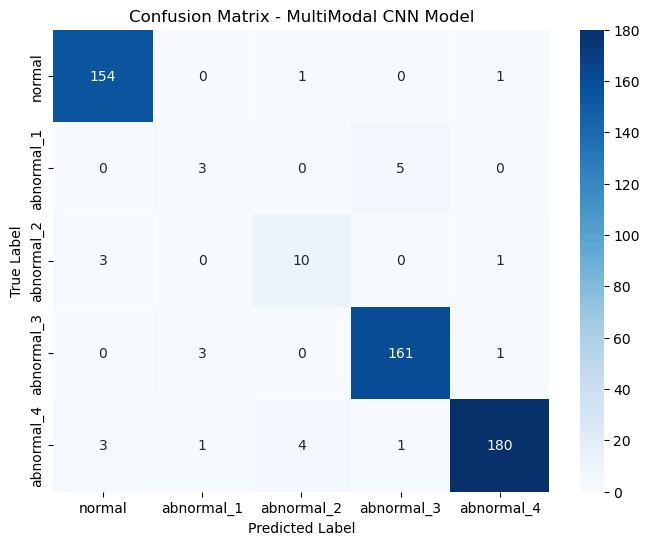

Macro-average Precision-Recall AUC: 0.8821

🔁 Run 2/5 -------------------
Epoch [1/50] | Train Loss: 0.1446 | Val Macro-F1: 0.7971
✅ Best model saved at epoch 1 (Macro-F1: 0.7971)
Epoch [2/50] | Train Loss: 0.0388 | Val Macro-F1: 0.8219
✅ Best model saved at epoch 2 (Macro-F1: 0.8219)
Epoch [3/50] | Train Loss: 0.0257 | Val Macro-F1: 0.8591
✅ Best model saved at epoch 3 (Macro-F1: 0.8591)
Epoch [4/50] | Train Loss: 0.0183 | Val Macro-F1: 0.8343
Epoch [5/50] | Train Loss: 0.0156 | Val Macro-F1: 0.7820
Epoch [6/50] | Train Loss: 0.0119 | Val Macro-F1: 0.8999
✅ Best model saved at epoch 6 (Macro-F1: 0.8999)
Epoch [7/50] | Train Loss: 0.0090 | Val Macro-F1: 0.8905
Epoch [8/50] | Train Loss: 0.0083 | Val Macro-F1: 0.8981
Epoch [9/50] | Train Loss: 0.0117 | Val Macro-F1: 0.9176
✅ Best model saved at epoch 9 (Macro-F1: 0.9176)
Epoch [10/50] | Train Loss: 0.0101 | Val Macro-F1: 0.9222
✅ Best model saved at epoch 10 (Macro-F1: 0.9222)
Epoch [11/50] | Train Loss: 0.0061 | Val Macro-F1: 0.9222
Ep

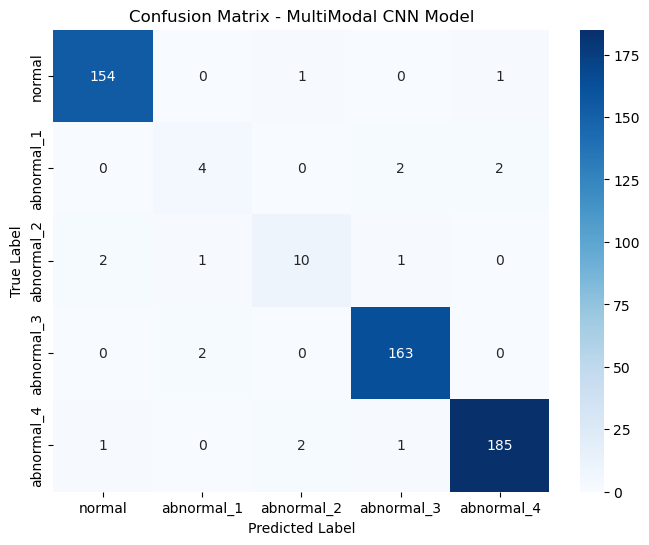

Macro-average Precision-Recall AUC: 0.8694

🔁 Run 3/5 -------------------
Epoch [1/50] | Train Loss: 0.1460 | Val Macro-F1: 0.8069
✅ Best model saved at epoch 1 (Macro-F1: 0.8069)
Epoch [2/50] | Train Loss: 0.0395 | Val Macro-F1: 0.8485
✅ Best model saved at epoch 2 (Macro-F1: 0.8485)
Epoch [3/50] | Train Loss: 0.0255 | Val Macro-F1: 0.8929
✅ Best model saved at epoch 3 (Macro-F1: 0.8929)
Epoch [4/50] | Train Loss: 0.0183 | Val Macro-F1: 0.9043
✅ Best model saved at epoch 4 (Macro-F1: 0.9043)
Epoch [5/50] | Train Loss: 0.0185 | Val Macro-F1: 0.8815
Epoch [6/50] | Train Loss: 0.0145 | Val Macro-F1: 0.9107
✅ Best model saved at epoch 6 (Macro-F1: 0.9107)
Epoch [7/50] | Train Loss: 0.0123 | Val Macro-F1: 0.9167
✅ Best model saved at epoch 7 (Macro-F1: 0.9167)
Epoch [8/50] | Train Loss: 0.0130 | Val Macro-F1: 0.8922
Epoch [9/50] | Train Loss: 0.0083 | Val Macro-F1: 0.9377
✅ Best model saved at epoch 9 (Macro-F1: 0.9377)
Epoch [10/50] | Train Loss: 0.0093 | Val Macro-F1: 0.9107
Epoch [11/50

KeyboardInterrupt: 

In [ ]:
# hyperparmeter tuning 결과로 얻은 최적의 config
best_config = {'dropout_rate': 0.3, 'conv2d1_kernel': 3, 'conv2d2_kernel': 3, 'tcn_kernel_size': 3, 'tcn_channels': [32, 64, 128], 'fc1_dim': 256, 'embed_dim': 64, 'num_heads': 2}


# Directory setup
model_dir = "final_results/multimodal"
os.makedirs(model_dir, exist_ok=True)

# Metrics storage
class_names = ["normal", "abnormal_1", "abnormal_2", "abnormal_3", "abnormal_4"]
macro_f1_list = []
class_f1_lists = []

n_runs = 5  # test with Model 1

for run in range(n_runs):
    run_dir = os.path.join(model_dir, f"trial_{run+1}")
    os.makedirs(run_dir, exist_ok=True)

    print(f"\n🔁 Run {run+1}/{n_runs} -------------------")

    # 2. Model build, optimizer, criterion
    model = build_model_from_config(best_config).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00025, weight_decay=1e-4)
    criterion = FocalLoss(alpha=0.75, gamma=3.0).to(device)

    # 3. Training with early stopping & best-model save
    best_model_path = os.path.join(run_dir, "best_model.pth")
    trained_model, _ = train_model_macro_f1_with_attn(
        model, train_loader, val_loader,
        criterion, optimizer,
        num_epochs=50,
        device=device,
        patience=5,
        save_dir=run_dir  # ensure best_model saved here
    )
    # rename saved best model for clarity

    trained_model.load_state_dict(torch.load(best_model_path))
    trained_model.eval()
    y_true, y_pred = [], []
    
    # 클래스별 로컬 인덱스 트래커
    local_idx = {cls: 0 for cls in class_names}
    correct_indices = {cls: [] for cls in class_names}
    
    with torch.no_grad():
        for stft_batch, raw_batch, y_batch in test_loader:
            stft_batch, raw_batch, y_batch = stft_batch.to(device), raw_batch.to(device), y_batch.to(device)
            outputs, _ = trained_model(stft_batch, raw_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
            for i in range(y_batch.size(0)):
                label_idx = y_batch[i].item()
                lbl = class_names[label_idx]
    
                # 예측이 정답과 같을 때만 기록
                if predicted[i] == y_batch[i]:
                    correct_indices[lbl].append(local_idx[lbl])
    
                # 무조건 클래스별 로컬 인덱스는 증가시킴
                local_idx[lbl] += 1

                
    
    # Compute metrics
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(len(class_names)), zero_division=0)
    
    macro_f1_list.append(macro_f1)
    class_f1_lists.append(f1.tolist())
    
    print(f"✅ Run {run+1} - Macro F1: {macro_f1:.4f} | Per-Class F1: {np.round(f1, 3)}")
    
    # Save metrics.json in expanded format
    metrics = {
        "macro_f1": float(macro_f1),
        "accuracy": float(acc),
        "class_scores": {
            class_names[i]: {
                "precision": float(precision[i]),
                "recall": float(recall[i]),
                "f1": float(f1[i])
            }
            for i in range(len(class_names))
        }
    }
    with open(os.path.join(run_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)
    
        
    # 6. Save predicted_indices.json
    with open(os.path.join(run_dir, "predicted_indices.json"), "w") as f:
        json.dump(correct_indices, f, indent=4)

    # Optionally run detailed evaluation
    evaluate_model(trained_model, test_loader, device, class_names)

In [ ]:
# 2) Model 2 (튜닝된 하이퍼파라미터) 종료 후
model2_dir = "final_results/multimodal"
save_summary(model2_dir, n_runs, class_names)


In [ ]:
# ─────────────────────────────────────────────
# 1. Best model & predicted index 불러오기
# ─────────────────────────────────────────────
def get_best_model_and_indices(model_dir):
    trials = sorted([
        d for d in os.listdir(model_dir)
        if d.startswith("trial_")
    ])
    best_trial = trials[0]  # 또는 성능 기준 선택 가능
    trial_path = os.path.join(model_dir, best_trial)
    return (
        os.path.join(trial_path, "best_model.pth"),
        os.path.join(trial_path, "predicted_indices.json")
    )

model_dir = "final_results_0518/model_2_end2end_tuning"
best_model_path, predicted_indices_path = get_best_model_and_indices(model_dir)

# ─────────────────────────────────────────────
# 2. 모델 로드
# ─────────────────────────────────────────────
model = build_model_from_config(best_config).to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

# ─────────────────────────────────────────────
# 3. 맞춘 인덱스 중에서 클래스별 1개 랜덤 선택
# ─────────────────────────────────────────────
with open(predicted_indices_path, "r") as f:
    correct_indices = json.load(f)

class_names = ["normal", "abnormal_1", "abnormal_2", "abnormal_3", "abnormal_4"]
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

sample_indices = {
    cls: random.choice(correct_indices[cls])
    for cls in class_names if correct_indices[cls]
}

dataset = test_loader.dataset
selected_stft, selected_raw, selected_labels = [], [], []

for cls, idx in sample_indices.items():
    x_stft, x_raw, _ = dataset[idx]
    selected_stft.append(x_stft.unsqueeze(0))
    selected_raw.append(x_raw.unsqueeze(0))
    selected_labels.append(torch.tensor([class_to_idx[cls]]))

selected_stft = torch.cat(selected_stft, dim=0).to(device)
selected_raw  = torch.cat(selected_raw,  dim=0).to(device)
selected_labels = torch.cat(selected_labels, dim=0).to(device)

# ─────────────────────────────────────────────
# 4. SHAP 계산용 background 샘플 준비 (train set)
# ─────────────────────────────────────────────
num_classes = 5
bg_per_class = 50
train_ds = train_loader.dataset
train_stft_array = train_ds.stft_data
train_raw_array  = train_ds.raw_data
train_labels     = train_ds.labels

background_stft_list, background_raw_list = [], []
for cls_idx in range(num_classes):
    cls_inds = np.where(train_labels == cls_idx)[0]
    chosen = np.random.choice(cls_inds, min(bg_per_class, len(cls_inds)), replace=False)
    background_stft_list.append(train_stft_array[chosen])
    background_raw_list.append(train_raw_array[chosen])

background_stft_tensor = torch.tensor(np.concatenate(background_stft_list), dtype=torch.float32, device=device)
background_raw_tensor  = torch.tensor(np.concatenate(background_raw_list),  dtype=torch.float32, device=device)

# ─────────────────────────────────────────────
# 5. SHAP 계산
# ─────────────────────────────────────────────
shap_values = compute_shap_for_selected_samples(
    model=model,
    background_stft=background_stft_tensor,
    background_raw=background_raw_tensor,
    selected_stft=selected_stft,
    selected_raw=selected_raw
)

# ─────────────────────────────────────────────
# 6. Attention Map 계산 (Head별 저장)
# ─────────────────────────────────────────────
model.eval()
attention_maps = []
grid_h, grid_w = 7, 8

with torch.no_grad():
    _, attn_weights = model(selected_stft, selected_raw)  # (B, H, T_q, T_kv)

for i in range(selected_stft.size(0)):
    head_maps = []
    for h in range(attn_weights.size(1)):
        map_2d = attn_weights[i, h].mean(dim=0).view(grid_h, grid_w).cpu().numpy()
        head_maps.append(map_2d)
    attention_maps.append(np.stack(head_maps))  # (H, 7, 8)

attention_maps_np = np.stack(attention_maps)  # (B, H, 7, 8)

# ─────────────────────────────────────────────
# 7. SHAP → 클래스별로 추출 (예측 기반)
# ─────────────────────────────────────────────
stft_shap_np = np.stack([
    shap_values[class_to_idx[cls]][0][i]
    for i, (cls, _) in enumerate(sample_indices.items())
])
raw_shap_np = np.stack([
    shap_values[class_to_idx[cls]][1][i]
    for i, (cls, _) in enumerate(sample_indices.items())
])

# ─────────────────────────────────────────────
# 8. 저장
# ─────────────────────────────────────────────
save_dir = "shap_attention_results/multimodal"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "attention_maps.npy"), attention_maps_np)
np.save(os.path.join(save_dir, "stft_shap_values.npy"), stft_shap_np)
np.save(os.path.join(save_dir, "raw_shap_values.npy"), raw_shap_np)

print("✅ 저장 완료:")
print(" - attention_maps.npy", attention_maps_np.shape)
print(" - stft_shap_values.npy", stft_shap_np.shape)
print(" - raw_shap_values.npy", raw_shap_np.shape)

### 2. Unimodal

In [ ]:
# 유니모달 2D CNN 모델 정의

class CNN2D_Model(nn.Module):
    def __init__(self, config, num_classes=5):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(
            3, 32, 
            kernel_size=config['conv2d1_kernel'], 
            padding=(config['conv2d1_kernel'] - 1) // 2
        )
        self.bn2d_1 = nn.BatchNorm2d(32)

        self.conv2d_2 = nn.Conv2d(
            32, 64, 
            kernel_size=config['conv2d2_kernel'], 
            stride=2,
            padding=(config['conv2d2_kernel'] - 1) // 2
        )
        self.bn2d_2 = nn.BatchNorm2d(64)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn2d_1(self.conv2d_1(x)))
        x = F.relu(self.bn2d_2(self.conv2d_2(x)))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# 유니모달 1D TCN 모델 정의
class TCN1D_Model(nn.Module):
    def __init__(self, config, num_classes=5):
        super().__init__()
        self.tcn = TemporalConvNet(
            in_channels=3,
            num_channels=config['tcn_channels'],
            kernel_size=config['tcn_kernel_size'],
            dropout=config['dropout_rate']
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(config['tcn_channels'][-1], num_classes)

    def forward(self, x):
        x = self.tcn(x)  # (B, C, L)
        x = self.global_pool(x).squeeze(-1)  # (B, C)
        x = self.fc(x)
        return x



In [ ]:
# 유니모달 CNN 학습 함수

def train_2d_cnn(model, train_loader, val_loader, criterion, optimizer,
                             num_epochs, device, patience=5, save_dir=None):
    best_val_f1 = 0.0
    val_macro_f1_list = []
    epochs_no_improve = 0

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        best_model_path = os.path.join(save_dir, 'best_model_single_input.pth')
    else:
        best_model_path = 'best_model_single_input.pth'

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_running_loss = 0.0
        y_true, y_pred = [], []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                val_running_loss += loss.item() * x_val.size(0)

                _, predicted = torch.max(outputs, 1)
                y_true.extend(y_val.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_f1 = f1_score(y_true, y_pred, average='macro')
        val_macro_f1_list.append(val_f1)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f} | Val Macro-F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), best_model_path)
            epochs_no_improve = 0
            print(f"✅ Best model saved at epoch {epoch+1} (Macro-F1: {val_f1:.4f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"⛔ Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                break

    model.load_state_dict(torch.load(best_model_path))
    return model, val_macro_f1_list


def train_1d_tcn(model, train_loader, val_loader, criterion, optimizer, 
                      num_epochs, device, patience=5, save_dir="saved_models_tcn1d"):
    os.makedirs(save_dir, exist_ok=True)
    
    best_val_f1 = 0.0
    best_model_path = os.path.join(save_dir, 'best_tcn1d_model.pth')
    val_macro_f1_list = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for raw_batch, y_batch in train_loader:
            raw_batch, y_batch = raw_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(raw_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * raw_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for raw_val, y_val in val_loader:
                raw_val, y_val = raw_val.to(device), y_val.to(device)
                outputs = model(raw_val)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(y_val.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_f1 = f1_score(y_true, y_pred, average='macro')
        val_macro_f1_list.append(val_f1)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f} | Val Macro-F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), best_model_path)
            print(f"✅ Best model saved at epoch {epoch+1} (Macro-F1: {val_f1:.4f})")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"⛔ Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                break

    model.load_state_dict(torch.load(best_model_path))
    return model, val_macro_f1_list

In [ ]:
# Unimodal 모델 평가 함수 (Confusion Matrix 포함)
def evaluate_model_with_confmat(model, data_loader, device, label_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in data_loader:
            if isinstance(batch, (list, tuple)) and len(batch) == 3:
                stft, raw, y = batch
                stft, raw, y = stft.to(device), raw.to(device), y.to(device)
                try:
                    out = model(stft, raw)
                except TypeError:
                    out = model(stft)
            else:
                x, y = batch
                x, y = x.to(device), y.to(device)
                out = model(x)

            if isinstance(out, tuple): out = out[0]
            _, pred = torch.max(out, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    # F1
    macro = f1_score(y_true, y_pred, average="macro")
    per_class = f1_score(y_true, y_pred, average=None)
    print("▶ Evaluation")
    print(f"  Macro F1: {macro:.4f}")
    for i, cls in enumerate(label_names):
        print(f"  {cls:<12}: {per_class[i]:.4f}")


    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - MultiModal CNN Model")
    plt.show()

    n_classes = len(label_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))


In [ ]:
def save_summary_single_model(model_dir, class_names):
    metrics_path = os.path.join(model_dir, "metrics.json")
    with open(metrics_path, "r") as f:
        m = json.load(f)

    summary = {
        "macro_f1": {
            "mean": float(m["macro_f1"]),
            "std": 0.0
        },
        "accuracy": {
            "mean": float(m.get("accuracy", 0)),
            "std": 0.0
        },
        "class_scores": {
            cls: {
                "precision": {"mean": float(m["class_scores"][cls]["precision"]), "std": 0.0},
                "recall":    {"mean": float(m["class_scores"][cls]["recall"]),    "std": 0.0},
                "f1":        {"mean": float(m["class_scores"][cls]["f1"]),        "std": 0.0}
            }
            for cls in class_names
        }
    }

    # JSON 저장
    with open(os.path.join(model_dir, "summary.json"), "w") as f:
        json.dump(summary, f, indent=2)

    # CSV 저장
    rows = [
        {"metric": "macro_f1", "mean": summary["macro_f1"]["mean"], "std": 0.0},
        {"metric": "accuracy", "mean": summary["accuracy"]["mean"], "std": 0.0}
    ]
    for cls in class_names:
        for metric in ["precision", "recall", "f1"]:
            rows.append({
                "metric": f"{cls}_{metric}",
                "mean": summary["class_scores"][cls][metric]["mean"],
                "std": 0.0
            })
    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(model_dir, "summary.csv"), index=False)
    print(f"✅ Saved single-model summary in {model_dir}")

In [ ]:
# ─────────────────────────────────────────────────
# Configuration
# ─────────────────────────────────────────────────
n_runs      = 5
class_names = ["normal","abnormal_1","abnormal_2","abnormal_3","abnormal_4"]
base_dir    = "final_results"
os.makedirs(base_dir, exist_ok=True)
best_config = {'dropout_rate': 0.3, 'conv2d1_kernel': 3, 'conv2d2_kernel': 3, 'tcn_kernel_size': 3, 'tcn_channels': [32, 64, 128], 'fc1_dim': 256, 'embed_dim': 64, 'num_heads': 2}

# ─────────────────────────────────────────────────
# Single loop: CNN2D → TCN1D → Transfer fine-tune each run
for run in range(1, n_runs+1):
    print(f"\n=== Run {run}/{n_runs} ===")

    print("======Unimodal : 2D CNN======")
    cnn_dir = os.path.join(base_dir, "2d_cnn", f"trial_{run}")
    os.makedirs(cnn_dir, exist_ok=True)

    # 모델 정의 및 학습
    cnn = CNN2D_Model(config=best_config, num_classes=5).to(device)
    opt = torch.optim.Adam(cnn.parameters(), lr=2.5e-4, weight_decay=1e-4)
    crit = FocalLoss(alpha=0.75, gamma=3.0).to(device)
    cnn, _ = train_2d_cnn(
        cnn, train_loader_stft, val_loader_stft,
        crit, opt, num_epochs=50, device=device,
        patience=5, save_dir=cnn_dir
    )

    # 모델 로드
    ckpt_files = [f for f in os.listdir(cnn_dir) if f.endswith('.pth')]
    cnn_ckpt = os.path.join(cnn_dir, sorted(ckpt_files)[0])
    cnn.load_state_dict(torch.load(cnn_ckpt))

    # 평가 및 metrics 저장
    cnn.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader_stft:
            x, y = x.to(device), y.to(device)
            out = cnn(x)
            _, pred = out.max(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=range(len(class_names)), zero_division=0
    )

    cnn_metrics = {
        "macro_f1": float(macro_f1),
        "accuracy": float(acc),
        "class_scores": {
            class_names[i]: {
                "precision": float(precision[i]),
                "recall": float(recall[i]),
                "f1": float(f1[i])
            }
            for i in range(len(class_names))
        }
    }

    with open(os.path.join(cnn_dir, "metrics.json"), "w") as f:
        json.dump(cnn_metrics, f, indent=4)

    print(f"✅ Run {run} - Macro F1: {macro_f1:.4f}")

    evaluate_model_with_confmat(cnn, test_loader_stft, device, class_names)


    
    print ("======Unimodal : 1D TCN======")

    # 2) 1D TCN
    from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
    import os, json, torch
    
    # ─────────────────────────────────────────────────
    # Run Loop: 1D TCN Only
    # ─────────────────────────────────────────────────
    print(f"\n=== Run {run}/{n_runs} ===")
    print("======Unimodal : 1D TCN======")

    tcn_dir = os.path.join(base_dir, "1d_tcn", f"trial_{run}")
    os.makedirs(tcn_dir, exist_ok=True)

    # 모델 정의 및 학습
    tcn = TCN1D_Model(config=best_config, num_classes=5).to(device)
    opt = torch.optim.Adam(tcn.parameters(), lr=2.5e-4, weight_decay=1e-4)
    crit = FocalLoss(alpha=0.75, gamma=3.0).to(device)
    tcn, _ = train_1d_tcn(
        tcn, train_loader_raw, val_loader_raw,
        optimizer=opt, criterion=crit,
        num_epochs=50, device=device,
        patience=5, save_dir=tcn_dir
    )
    
    # 체크포인트 로드
    tcn_ckpt = os.path.join(tcn_dir, sorted(os.listdir(tcn_dir))[0])
    tcn.load_state_dict(torch.load(tcn_ckpt))

    # 테스트 평가 및 메트릭 계산
    tcn.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader_raw:
            x, y = x.to(device), y.to(device)
            out = tcn(x)
            _, pred = out.max(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=range(len(class_names)), zero_division=0
    )

    tcn_metrics = {
        "macro_f1": float(macro_f1),
        "accuracy": float(acc),
        "class_scores": {
            class_names[i]: {
                "precision": float(precision[i]),
                "recall": float(recall[i]),
                "f1": float(f1[i])
            }
            for i in range(len(class_names))
        }
    }

    with open(os.path.join(tcn_dir, "metrics.json"), "w") as f:
        json.dump(tcn_metrics, f, indent=4)

    print(f"✅ Run {run} - Macro F1: {macro_f1:.4f}")

    evaluate_model_with_confmat(tcn, test_loader_raw, device, class_names)
    
print("\n🎉 All runs completed.")

In [ ]:
# summary 저장 함수
def save_summary_across_trials(model_dir, class_names, n_runs=5):
    macro_f1s = []
    accuracies = []
    precisions = {cls: [] for cls in class_names}
    recalls    = {cls: [] for cls in class_names}
    f1s        = {cls: [] for cls in class_names}

    for r in range(1, n_runs + 1):
        trial_path = os.path.join(model_dir, f"trial_{r}", "metrics.json")
        if not os.path.exists(trial_path):
            print(f"⚠️ Missing: {trial_path}")
            continue
        with open(trial_path, "r") as f:
            m = json.load(f)
        macro_f1s.append(m["macro_f1"])
        accuracies.append(m["accuracy"])
        for cls in class_names:
            precisions[cls].append(m["class_scores"][cls]["precision"])
            recalls[cls].append(m["class_scores"][cls]["recall"])
            f1s[cls].append(m["class_scores"][cls]["f1"])

    summary = {
        "macro_f1": {
            "mean": float(np.mean(macro_f1s)),
            "std": float(np.std(macro_f1s))
        },
        "accuracy": {
            "mean": float(np.mean(accuracies)),
            "std": float(np.std(accuracies))
        },
        "class_scores": {
            cls: {
                "precision": {"mean": float(np.mean(precisions[cls])), "std": float(np.std(precisions[cls]))},
                "recall":    {"mean": float(np.mean(recalls[cls])),    "std": float(np.std(recalls[cls]))},
                "f1":        {"mean": float(np.mean(f1s[cls])),        "std": float(np.std(f1s[cls]))}
            }
            for cls in class_names
        }
    }

    # 저장
    with open(os.path.join(model_dir, "summary.json"), "w") as f:
        json.dump(summary, f, indent=2)

    print(f"✅ Summary saved to {model_dir}/summary.json")

In [ ]:
cnn_model_dir = os.path.join(base_dir, "2d_cnn")
tcn_model_dir = os.path.join(base_dir, "1d_tcn")

save_summary_across_trials(cnn_model_dir, class_names, n_runs=5)
save_summary_across_trials(tcn_model_dir, class_names, n_runs=5)